# Setup

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [1]:
!mamba  install  -q -y -c rapidsai -c conda-forge -c nvidia cucim cuml #cupy
!git clone https://github.com/MaximilianHoffmann/test.git
!pip install --ignore-installed  --quiet ./test
!wget "https://owncloud.charite.de/owncloud/index.php/s/zc9NTVJMw8AiuQn/download?path=%2F&files=20230611_export.h5" -O data.h5

# Analysis

In [2]:
import h5py as h5
import numpy as np
import cupy as cp
from tqdm.auto import tqdm
from wholebrain import util,cluster,spatial,regression
from functools import partialmethod
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.gridspec import GridSpec
# TURN TQDM ON/OFF
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

/home/hoffmmax/mambaforge/envs/hoffmann_et_al/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hoffmmax/mambaforge/envs/hoffmann_et_al/lib/python3.8/site-packages/rmm/__init__.py:56: FutureWarning: Use of 'rmm.rmm_cupy_allocator' is deprecated and will be removed. 'rmm_cupy_allocator' now lives in the 'rmm.allocators.cupy' sub-module, please update your imports.
  warnings.warn(


In [3]:
def load_dset(name):
    with h5.File('./data.h5','r') as fh5:
        return fh5[name]['coords'][:],fh5[name]['dff'][:],fh5[name]['traces'][:]

In [4]:
data={}
with h5.File('./data.h5','r') as fh5:
    names=[n for n in fh5.keys()]
    print('Datasets:', names)

Datasets: ['dset_0', 'dset_1', 'dset_2', 'dset_3', 'dset_4', 'dset_5']


In [6]:
n_repeats=5

pars={"r2_scan":{"do":True, "s_bins":[5,10,25,50,100,150,200,500],"n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"alphas":np.geomspace(1,10000,20).tolist(),"n_repeats":n_repeats},
 "distortion": 
     { "do": True, "split":2}}


measures=['distortion_euclidian', 'similarity_corr', 'similarity_cov']

In [7]:
sim_list=[]
for name in tqdm(names):
    coords,dff,traces=load_dset(name)
    dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)
    
    sim_val = util.distortion(
            pars["r2_scan"]["s_bins"],
            pars["r2_scan"]["n_pred_list"],
            coords,
            dff_mu,
            n_repeats=pars["r2_scan"]["n_repeats"],
            n_targets=dff_mu.shape[1]//pars["distortion"]["split"],
        )
    sim_list.append(sim_val)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

  0%|                                                     | 0/8 [00:00<?, ?it/s]


  0%|                                                     | 0/5 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:02<00:09,  2.44s/it]


 40%|██████████████████                           | 2/5 [00:03<00:04,  1.34s/it]


 60%|███████████████████████████                  | 3/5 [00:03<00:01,  1.02it/s]


 80%|████████████████████████████████████         | 4/5 [00:04<00:00,  1.24it/s]


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.40it/s]


                                                                                

 12%|█████▋                                       | 1/8 [00:04<00:32,  4.66s/it]


  0%|                                                     | 0/5 [00:00<?, ?it/s]


 20%|█████████                                    | 1/5 [00:00<00:02,  1.81it/s]


 40%|█

/home/hoffmmax/mambaforge/envs/hoffmann_et_al/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hoffmmax/mambaforge/envs/hoffmann_et_al/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3962700/1477920215.py:64: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs['B'].set(xscale='log',xlim=[0,5e3],ylim=[0,0.5],xlabel='Number of predictors',ylabel='Distortion stress')
/tmp/ipykernel_3962700/1477920215.py:65: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs['D'].set(xscale='log',xlim=[0,5e3],ylim=[0,1],xlabel='Number of predictors',ylabel='Similarity')


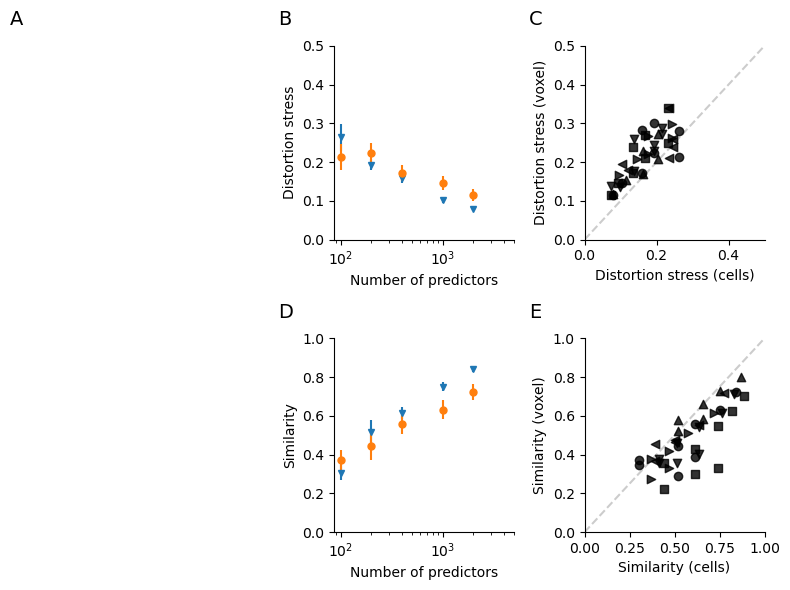

In [9]:
name_example='dset_0'

ms=5
lw=1
opac=0.1
vx_sz=50
vx_list=[50,100,200]


fig = plt.figure(figsize=(8,6))
gs0 = GridSpec(2,3, width_ratios=[1.1,1,1])
axs = dict()
axs['A'] = fig.add_subplot(gs0[:, 0])
axs['B'] = fig.add_subplot(gs0[0, 1])
axs['C'] = fig.add_subplot(gs0[0, 2])
axs['D'] = fig.add_subplot(gs0[1, 1])
axs['E'] = fig.add_subplot(gs0[1, 2])






markers = ['o','v','^','<','>','s','*','+','x']
for ian,name in enumerate(names):
    #with open(os.path.join(p_in,'pars.json')) as f:
    #    pars=json.load(f)
    sim=sim_list[ian]
    
    for vx in vx_list:
        x=sim.sel(shuffled=False,measure=measures[0],voxel_size=5).mean('repeats')
        y=sim.sel(shuffled=False,measure=measures[0],voxel_size=vx).mean('repeats')
        axs["C"].scatter(x,y,alpha=0.8,c='k',marker=markers[ian])
     
        x=sim.sel(shuffled=False,measure=measures[1],voxel_size=5).mean('repeats')
        y=sim.sel(shuffled=False,measure=measures[1],voxel_size=vx).mean('repeats')
        axs["E"].scatter(x,y,alpha=0.8,c='k',marker=markers[ian])


axs["C"].set(xlim=[0,0.5],ylim=[0,0.5],xlabel="Distortion stress (cells)",ylabel="Distortion stress (voxel)")
axs["E"].set(xlim=[0,1],ylim=[0,1],xlabel="Similarity (cells)",ylabel="Similarity (voxel)")
axs["E"].plot([0,1],[0,1],'--',alpha=0.2,c='k')
axs["C"].plot([0,1],[0,1],'--',alpha=0.2,c='k')

nn=5

sim=sim_list[0]

y=sim.sel(shuffled=False,measure=measures[0],voxel_size=5).mean('repeats')[:nn]
err=sim.sel(shuffled=False,measure=measures[0],voxel_size=5).std('repeats')[:nn]
axs['B'].errorbar(sim.num_predictors[:nn],y,yerr=err,ls='',marker='v',ms=ms,label='cells')
y=sim.sel(shuffled=False,measure=measures[0],voxel_size=50).mean('repeats')[:nn]
err=sim.sel(shuffled=False,measure=measures[0],voxel_size=50).std('repeats')[:nn]
axs['B'].errorbar(sim.num_predictors[:nn],y,err,ls='',marker='o',ms=ms,label='voxel')


y=sim.sel(shuffled=False,measure=measures[1],voxel_size=5).mean('repeats')[:nn]
err=sim.sel(shuffled=False,measure=measures[1],voxel_size=5).std('repeats')[:nn]
axs['D'].errorbar(sim.num_predictors[:nn],y,err,ls='',marker='v',ms=ms,label='cells')
y=sim.sel(shuffled=False,measure=measures[1],voxel_size=50).mean('repeats')[:nn]
err=sim.sel(shuffled=False,measure=measures[1],voxel_size=50).std('repeats')[:nn]
axs['D'].errorbar(sim.num_predictors[:nn],y,err,ls='',marker='o',ms=ms,label='voxel')

axs['B'].set(xscale='log',xlim=[0,5e3],ylim=[0,0.5],xlabel='Number of predictors',ylabel='Distortion stress')
axs['D'].set(xscale='log',xlim=[0,5e3],ylim=[0,1],xlabel='Number of predictors',ylabel='Similarity')


#gs00 = gs0[2:,1].subgridspec(3, 1, hspace=0.2)
#axs['F'] = fig.add_subplot(gs00[0, 0])
#axs['F'].get_xaxis().set_visible(False)
#axs['G'] = fig.add_subplot(gs00[1, 0])
#axs['G'].get_xaxis().set_visible(False)
#axs['H'] = fig.add_subplot(gs00[2, 0])

axs['A'].axis('off')

trans = matplotlib.transforms.ScaledTranslation(-40/72, 15/72, fig.dpi_scale_trans)
for n, (key, ax) in enumerate(axs.items()):
    if key in ['A','B','C','D','E','F']:
        ax.text(0, 1, key, transform=ax.transAxes+trans, size=14, weight='regular')
sns.despine()
fig.tight_layout()
    

